In [2]:
#Maksymilian Podraza
#CS361 
#Multi Class Classifier

In [3]:
import os, random, itertools
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn.cluster
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [4]:
ratio_for_training = 0.80 
pat_s = 480
num_pat = 32

In [5]:
dataDirectory = "HMP_Dataset"

In [6]:
def initialSetupWithData():
    all_data = {}
    labels = next(os.walk(dataDirectory))[1]
    for label in labels:
        activity_folder_data = []
        label = label.lower()
        files = next(os.walk(os.path.join(dataDirectory, label)))[2]
        for file in files:
            with open(os.path.join(dataDirectory, label, file), 'r') as file:
                file_data = []
                for line in file.readlines():
                    x, y, z = [float(x) for x in line.split(" ")]
                    file_data.append((x, y, z))
            activity_folder_data.append(file_data)
        all_data[label] = activity_folder_data
    return all_data

In [7]:
def dataSplitter():
    train_dict = {}
    eval_dict = {}
    for label in all_data:
        random.shuffle(all_data[label])
        cutoff_index = max(int(len(all_data[label])*ratio_for_training), 3)
        train_dict[label] = all_data[label][:cutoff_index] 
        eval_dict[label] = all_data[label][cutoff_index:]
    return (train_dict, eval_dict)

In [8]:
def chunkifier(x, size = pat_s):
    chunkies = []
    i = 0
    while len(x[i:i+size]) == size:
        chunkies.append(x[i:i+size])
        i += size
    return chunkies

In [9]:
def flattifier(x): 
    return list(sum(x, ())) #this is a trick my friend showed me, not really sure how it works but it does lol

In [10]:
def createPatternData():
    pattern_building_data = []
    for label in train_dict:
        for file in train_dict[label]:
            for chunkifiedVector in chunkifier(file):
                pattern_building_data.append(flattifier(chunkifiedVector))
    return pattern_building_data

In [11]:
def featureHistogram(file):
    chunkies = [flattifier(x) for x in chunkifier(file)]
    histogram = [0 for i in range(num_pat)]
    patterns = clusterer.predict(chunkies)
    for pattern_index in patterns:
        histogram[pattern_index] += 1
    return histogram

In [12]:
def classifierFuncReturn_training_data():
    temp_data = []
    for label in train_dict:
        for file in train_dict[label]:
            histogram = featureHistogram(file)
            data = {'Activity': label}
            for i in range(len(histogram)):
                data[i] = histogram[i]
            temp_data.append(data)
    classifier_training_data = pd.DataFrame(temp_data)
    return classifier_training_data

In [13]:
def indepAndDep():
    indep = classifier_training_data[[i for i in range(num_pat)]]
    dep = classifier_training_data['Activity']
    return (indep, dep)

In [14]:
def indepAndDepEvaluation():
    indep = []
    dep = []
    for label in eval_dict:
        for file in eval_dict[label]:
            indep.append(featureHistogram(file))
            dep.append(label)
    return (indep, dep)

In [15]:
all_data = initialSetupWithData()

In [16]:
train_dict, eval_dict = dataSplitter()

In [17]:
pattern_building_data = createPatternData()

In [112]:
clusterer = KMeans(n_clusters=24, random_state=0, max_iter=500)

In [113]:
clusterer.fit(pattern_building_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=24, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [114]:
classifier_training_data = classifierFuncReturn_training_data()

In [115]:
indep, dep = indepAndDep()

In [116]:
classifier = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [117]:
classifier.fit(indep, dep)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [118]:
indep_eval, dep_eval = indepAndDepEvaluation()

In [119]:
dep_pred = classifier.predict(indep_eval)

In [120]:
confusion_matrix = metrics.confusion_matrix(dep_eval, dep_pred)
print(pd.DataFrame(confusion_matrix))

    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0    3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1    0  12   1   0   4   2   0   0   0   0   0   0   0   0   0   2   0   0   
2    0   1   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3    0   0   0   6   0   1   0   0   0   0   0   0   0   0   0   0   0   0   
4    0   3   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   
5    0   0   0   0   0  18   1   0   0   0   0   1   0   0   0   0   0   0   
6    0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   
7    0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
8    0   0   0   0   0   0   0   0  14   2   1   0   0   2   0   1   0   0   
9    0   0   0   0   0   0   0   0   2   0   0   0   0   1   0   1   0   0   
10   0   0   0   0   0   0   0   0   3   1   0   0   0   2   0   0   0   0   
11   0   0   0   0   0   0   0   0   0   0   0  20   0   0   0  

Text(0.5,0,'Classified label')

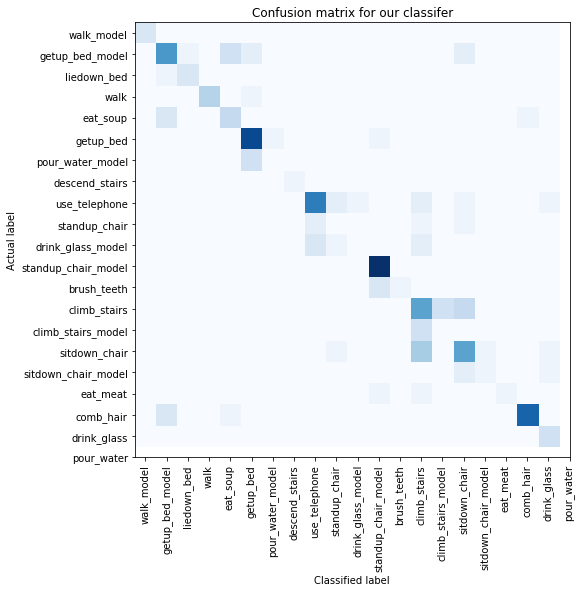

In [121]:
plt.figure(figsize=(8,8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for our classifer')
tick_marks = np.arange(len(eval_dict.keys()))
plt.xticks(tick_marks, eval_dict.keys(), rotation=90)
plt.yticks(tick_marks, eval_dict.keys())
plt.ylabel('Actual label')
plt.xlabel('Classified label')

In [122]:
print('Classification Report for our classider')
print(metrics.classification_report(dep_eval, dep_pred))

Classification Report for our classider
                     precision    recall  f1-score   support

        brush_teeth       1.00      1.00      1.00         3
       climb_stairs       0.63      0.57      0.60        21
 climb_stairs_model       0.75      0.75      0.75         4
          comb_hair       1.00      0.86      0.92         7
     descend_stairs       0.50      0.56      0.53         9
        drink_glass       0.72      0.90      0.80        20
  drink_glass_model       0.00      0.00      0.00         4
           eat_meat       1.00      1.00      1.00         1
          getup_bed       0.74      0.67      0.70        21
    getup_bed_model       0.00      0.00      0.00         4
        liedown_bed       0.00      0.00      0.00         6
         pour_water       0.80      1.00      0.89        20
   pour_water_model       1.00      0.25      0.40         4
      sitdown_chair       0.39      0.55      0.46        20
sitdown_chair_model       0.00      0.00    

In [28]:
def whole_program(r, p, n): 
    ratio_for_training = r
    pat_s = p
    num_pat = n
    all_data = initialSetupWithData()
    train_dict, eval_dict = dataSplitter()
    pattern_building_data = createPatternData()
    clusterer = KMeans(n_clusters=24, random_state=0, max_iter=500)
    clusterer.fit(pattern_building_data)
    classifier_training_data = classifierFuncReturn_training_data()
    indep, dep = indepAndDep()
    classifier = RandomForestClassifier(n_estimators=250, criterion='entropy')
    classifier.fit(indep, dep)
    indep_eval, dep_eval = indepAndDepEvaluation()
    dep_pred = classifier.predict(indep_eval)
    
    return metrics.precision_recall_fscore_support(dep_eval, dep_pred, average='weighted')[0]

In [29]:
import warnings
warnings.filterwarnings('ignore') #this gets rid of the warning otherwise we have a huge wall of red blocks

In [31]:
#this is the code I ran to find optimal k and d
#this takes a really long time so I just commented it out

'''testing_patterns = [4, 6, 8, 12, 16, 20, 24, 30, 32, 64]
testing_num_patterns = [8, 10, 24, 30, 32, 40, 48]
maximum = [0, 0 ,0]
for pattern in testing_patterns:
    for num in testing_num_patterns:
        returnVal = whole_program(.8, pattern, num)
        print(pattern, num, returnVal)
        if(returnVal > maximum[0]):
            maximum[0] = returnVal
            maximum[1] = pattern
            maximum[2] = num'''

4 8 0.6765598206141683
4 10 0.6832353284396763
4 24 0.6866487061438434
4 30 0.6849991877687529
4 32 0.6786160976704454
4 40 0.6800938644688643
4 48 0.6897880673674152
6 8 0.692124720689938
6 10 0.6840508093355919
6 24 0.6815559523809525
6 30 0.6925955765249243
6 32 0.6746542678336156
6 40 0.7034506556245687
6 48 0.6944269951063429
8 8 0.6833147860593514
8 10 0.690827101642319
8 24 0.6951960901417423
8 30 0.6867168737060041
8 32 0.6856354382332642
8 40 0.6627674430641821
8 48 0.6850121603034647
12 8 0.6811674195369847
12 10 0.6818913906142167
12 24 0.6769233719179372
12 30 0.6668410893454372
12 32 0.678245790200138
12 40 0.6674838476740651
12 48 0.6767187016454179
16 8 0.7004580557124035
16 10 0.6636753795721186
16 24 0.6865025879917184
16 30 0.698437526241874
16 32 0.6777630461326113
16 40 0.6824615853317798
16 48 0.6650784472898416
20 8 0.6807937016454179
20 10 0.6865412214596996
20 24 0.6749916387959866
20 30 0.6814945416901937
20 32 0.6963938060731539
20 40 0.6899184185379837
20 48 

In [35]:
print("Highest achieved precision:",maximum[0], "with k =", maximum[1], "and d =", maximum[2])

Highest achieved precision: 0.7034506556245687 with k = 6 and d = 40


In [40]:
#Running our classifier with the maximum k and d
whole_program(0.8, 6, 40)

0.6982863181504486

In [45]:
confusion_matrix = metrics.confusion_matrix(dep_eval, dep_pred)
confusion_matrix

array([[ 2,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0, 18,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  0],
       [ 0,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  6,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  3,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 18,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 19,  1,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0

Text(0.5,0,'Classified label')

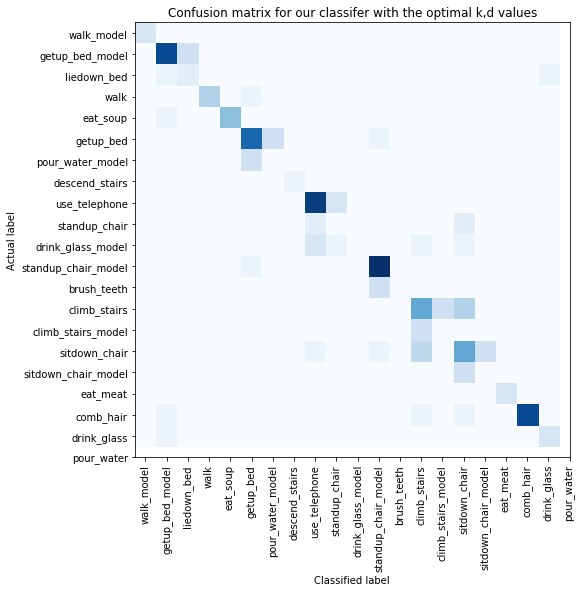

In [75]:
#Plot of the confusion matrix with the maximum k and d
plt.figure(figsize=(8,8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for our classifer with the optimal k,d values')
tick_marks = np.arange(len(eval_dict.keys()))
plt.xticks(tick_marks, eval_dict.keys(), rotation=90)
plt.yticks(tick_marks, eval_dict.keys())
plt.ylabel('Actual label')
plt.xlabel('Classified label')

In [43]:
print('Classification Report for our classifier with optimal k,d values')
print(metrics.classification_report(dep_eval, dep_pred))

Classification Report for our classifier with optimal k,d values
                     precision    recall  f1-score   support

        brush_teeth       1.00      0.67      0.80         3
       climb_stairs       0.75      0.86      0.80        21
 climb_stairs_model       0.50      0.25      0.33         4
          comb_hair       0.86      0.86      0.86         7
     descend_stairs       0.86      0.67      0.75         9
        drink_glass       0.78      0.90      0.84        20
  drink_glass_model       0.00      0.00      0.00         4
           eat_meat       1.00      1.00      1.00         1
          getup_bed       0.70      0.90      0.79        21
    getup_bed_model       0.00      0.00      0.00         4
        liedown_bed       1.00      0.17      0.29         6
         pour_water       0.80      1.00      0.89        20
   pour_water_model       0.00      0.00      0.00         4
      sitdown_chair       0.55      0.55      0.55        20
sitdown_chair_model

In [73]:
error_rate = 1 - 0.7034506556245687
print(error_rate)

0.29654934437543135
